## throughput for each 802.11 type, vs. time and GPS

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')
base_dir = '/Volumes/data/vehicular-traces-gaia'

# merge gps data with throughput for each 802.11 type (n, ac, ad)
def get_gps_thghpt(trace_nr):

    gps_data = pd.read_csv(os.path.join(base_dir, ('m1/trace-%s/gps-log.csv' % (trace_nr))))
    gps_data['timestamp'] = gps_data['timestamp'].astype(int)
    trace_data = gps_data[['timestamp', 'speed', 'lon', 'lat']]
    
    tp_files = {'m1' : ['consumer.1.out', 'n'], 'w4' : ['consumer.1.out', 'ac'], 'w4/tp-03' : ['consumer.5202.1.out', 'ad']}
    for node in tp_files:
        filename = tp_files[node][0]
        cname = tp_files[node][1]
        
        tp_data = pd.read_csv(os.path.join(base_dir, ('%s/trace-%s/%s' % (node, trace_nr, filename))), names = ['timestamp', 'rcvd-pkt', 'rcvd-bytes', 'duration', cname])
        trace_data = pd.merge(trace_data, tp_data[['timestamp', cname]], on = ['timestamp'], how = 'left')
    
    trace_data['trace-nr'] = trace_nr
    return trace_data

trace_nrs = ['301', '302', '303', '304', '401', '402', '403', '404', '405']
trace_data = pd.DataFrame()
for trace_nr in trace_nrs:
    trace_data = pd.concat([trace_data, get_gps_thghpt(trace_nr)])


FileNotFoundError: [Errno 2] File b'/Volumes/data/vehicular-traces-gaia/m1/trace-300/gps-log.csv' does not exist: b'/Volumes/data/vehicular-traces-gaia/m1/trace-300/gps-log.csv'

## map handling tools

In [28]:
import hashlib
import geopandas as gp
import mapping.openstreetmap as osm
import mapping.utils
import matplotlib
import matplotlib.pyplot as plt
import timeit
import shapely
import contextily as ctx
import numpy as np

# intersection coords (espg:4326)
LAT  = 41.111937
LON = -8.631084
# N, S, W, E limits of bbox
LATN = LAT + 0.001
LATS = LAT - 0.001
LONE = LON + 0.001
LONW = LON - 0.001

# intersection coords (espg:3857)
LAT_3857 = 5028862.95
LON_3857 = -960807.88

def add_basemap(ax, zoom, url = 'http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):

    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom = zoom, url = url)
    ax.imshow(basemap, extent = extent, interpolation = 'bilinear', alpha = 1.0)
    
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

def plot_map(data, 
         params = {
            'name' : 'sample-map',
            'title' : '# of data samples per 5x5 m cell' 
        }):
    
    fig = plt.figure(figsize = (7.5, 7.5))
    ax = fig.add_subplot(1, 1, 1)
    ax.xaxis.grid(True, ls = 'dotted', lw = 0.75)
    ax.yaxis.grid(True, ls = 'dotted', lw = 0.75)
    
    # map tiles are typically provided in Web Mercator (EPSG 3857), so we need to make sure to convert our data first to the same CRS to combine our polygons and background tiles in the same map
    data = data.to_crs(epsg = 3857)
    data.plot(ax = ax, zorder = 5, column = 'value', cmap = 'YlOrRd', legend = True, alpha = .75)
    add_basemap(ax, zoom = 17)

    xlim = ax.get_xlim()
    dx = (65.5 / 2.5)
    a = np.arange(LON_3857 - (dx * 10), LON_3857, dx)
    b = np.arange(LON_3857, LON_3857 + (dx * 20), dx)
    c = np.arange(-(20 * 10), 0, 20)
    d = np.arange(0, (20 * 20), 20)
    ax.set_xticks(a.tolist() + b.tolist())
    ax.set_xticklabels(c.tolist() + d.tolist())
    ax.set_xlim(xlim)
    
    ylim = ax.get_ylim()
    a = np.arange(LAT_3857 - (dx * 10), LAT_3857, dx)
    b = np.arange(LAT_3857, LAT_3857 + (dx * 20), dx)
    c = np.arange(-(20 * 10), 0, 20)
    d = np.arange(0, (20 * 20), 20)
    ax.set_yticks(a.tolist() + b.tolist())
    ax.set_yticklabels(c.tolist() + d.tolist())
    ax.set_ylim(ylim)
    
    ax.set_title(params['title'])
    ax.set_xlabel('xx dist (m)')
    ax.set_ylabel('yy dist (m)')
    
    plt.savefig(os.path.join(graphs_dir, ("%s.png" % (params['name']))), bbox_inches = 'tight', format = 'png')

def plot_cdf(data, metric, params):

    data = data.sort_values(by = [metric])
    if 'counts' not in data:
        cdf = data.groupby([metric]).size().reset_index(name = 'counts')
    else:
        cdf = data
    
    cdf['counts'] = np.array(cdf['counts'].cumsum(), dtype = float)
    cdf['counts'] = cdf['counts'] / cdf['counts'].values[-1]

    fontsize = 10
    linestyle = '-'
    linecolor = 'blue'

    fig = plt.figure(figsize = (6.0, 5.0))
    ax = fig.add_subplot(1, 1, 1)
    ax.xaxis.grid(True, ls = 'dotted', lw = 0.5)
    ax.yaxis.grid(True, ls = 'dotted', lw = 0.5)

    ax.set_title(params['title'], fontsize = fontsize)
    ax.plot(cdf[metric], cdf['counts'], 
        alpha = .75, 
        linewidth = 1.00, 
        color = linecolor, 
        linestyle = linestyle)

    ax.set_xlabel(params['x-label'], fontsize = fontsize)
    if 'x-limit' in params:
        ax.set_xlim(params['x-limit'])
        ax.set_xticks(params['x-ticks'])
        
    ax.set_ylabel("CDF", fontsize = fontsize)

    ax.set_yticks(np.arange(0.0, 1.1, 0.25))
    ax.set_ylim([0.0, 1.0])
    
    ax.tick_params(axis = 'both', which = 'major', labelsize = fontsize)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = fontsize)
    
    plt.tight_layout()
    plt.savefig(os.path.join(graphs_dir, ("%s.png" % (params['name']))), bbox_inches = 'tight', format = 'png')
    
graphs_dir = '/mnt/hgfs/data/vehicular-traces-gaia/graphs'
bbox = [LONW, LATS, LONE, LATN]
cell_size = 5.0

# get 5x5 m geodf grid
grid, w, h = osm.extract_cells(bbox = bbox, tags = ['ctx'], cell_size = cell_size)
# add cell ids to trace_data
mapping.utils.add_cells(trace_data, cell_size = cell_size, bbox = [LONW, LATS, LONE, LATN])


## vehicle movement

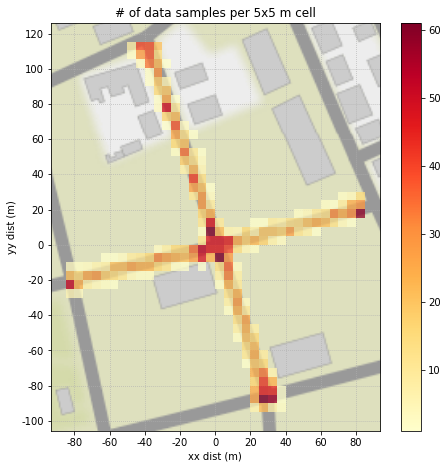

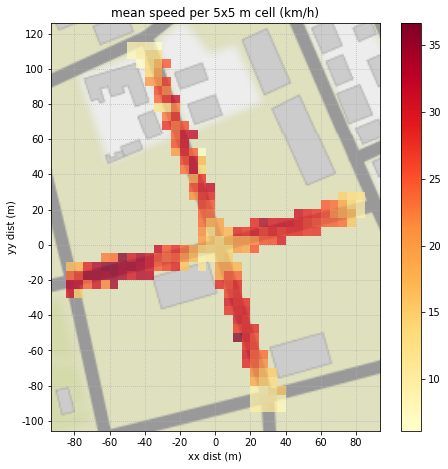

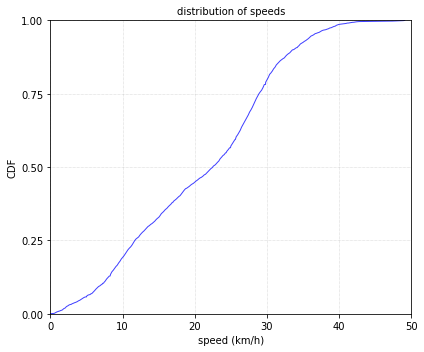

In [29]:
# distribution of sample points per cell
sample_nr = trace_data[trace_data['speed'] > 0.0].groupby(['cell_id']).size().reset_index(drop = False, name = 'value')
sample_nr = pd.merge(grid, sample_nr, on = ['cell_id'], how = 'inner')
plot_map(sample_nr, params = {'name' : 'sample-map', 'title' : '# of data samples per 5x5 m cell'})

# distribution of speed per cell
speed = trace_data[trace_data['speed'] > 0.0]
# convert from m/s to km/h
speed['speed'] = (speed['speed'] * 3.6).astype(float)
mspeed = speed.groupby(['cell_id'])['speed'].mean().reset_index(drop = False, name = 'value')
mspeed = pd.merge(grid, mspeed, on = ['cell_id'], how = 'inner')
plot_map(mspeed, params = {'name' : 'speed-map', 'title' : 'mean speed per 5x5 m cell (km/h)'})

# speed distribution
plot_cdf(speed, metric = 'speed', 
         params = {'x-label' : 'speed (km/h)', 'title' : 'distribution of speeds', 'name' : 'cdf-speed',
                  'x-limit' : [0.0, 50.0], 'x-ticks' : np.arange(0.0, 60.0, 10.0)})


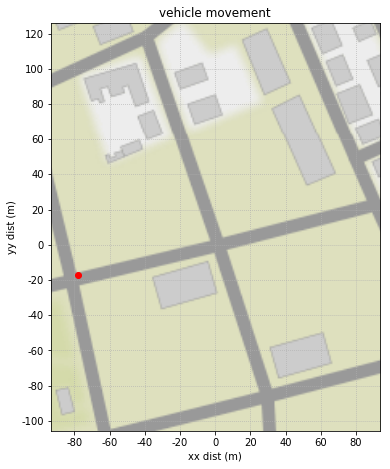

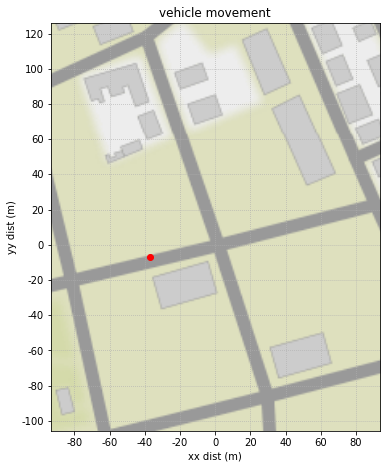

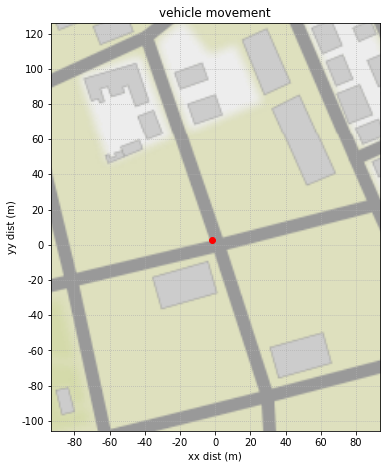

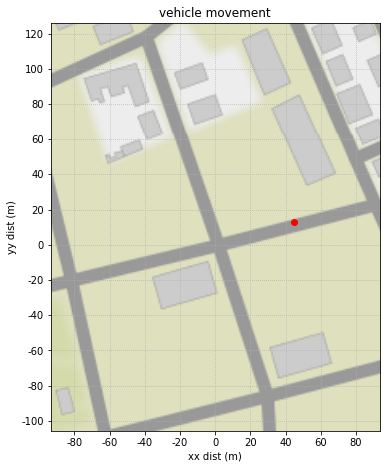

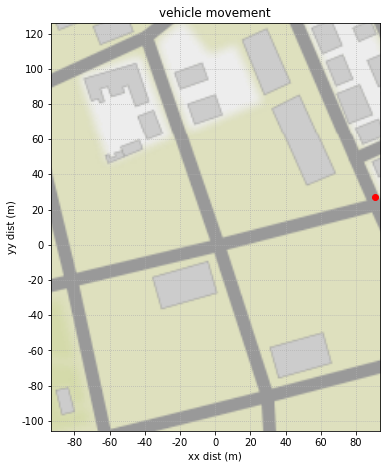

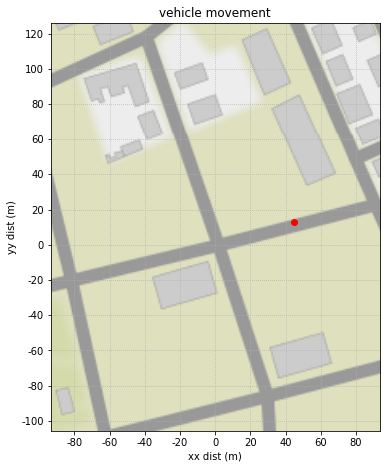

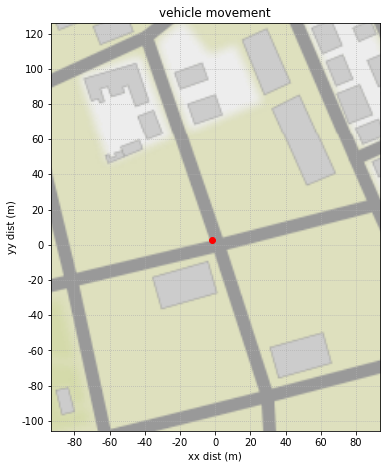

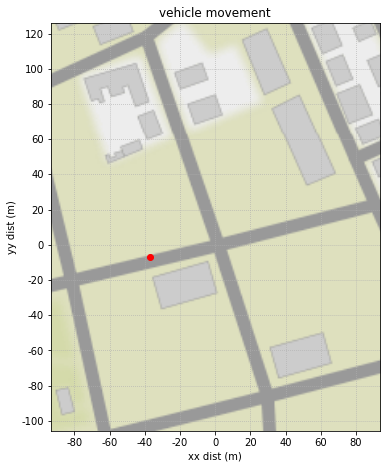

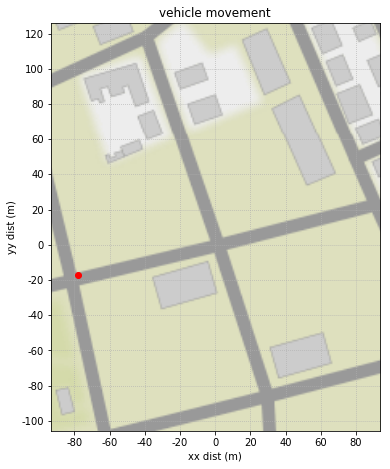

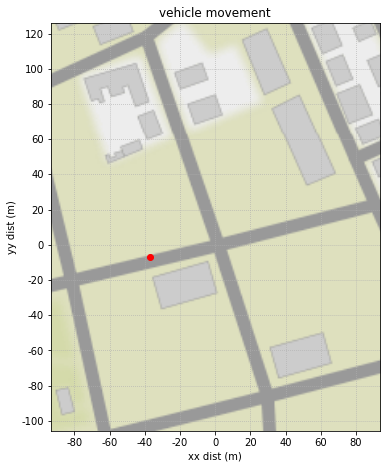

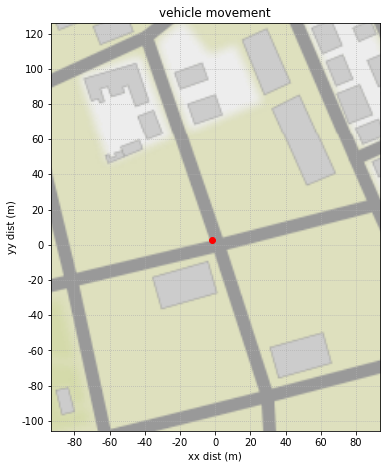

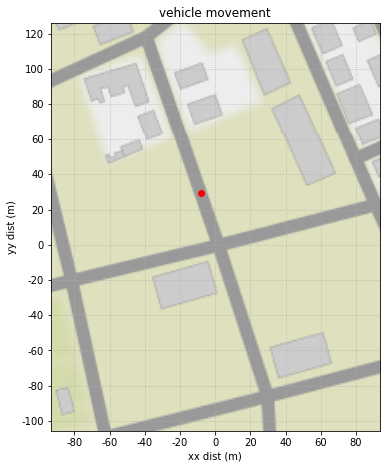

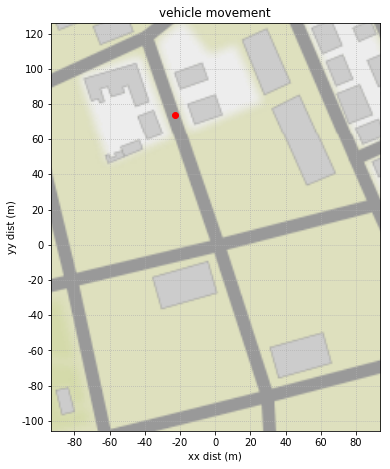

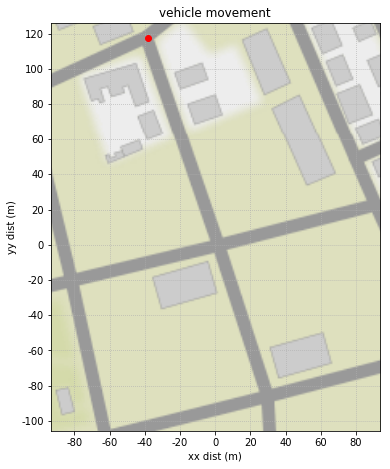

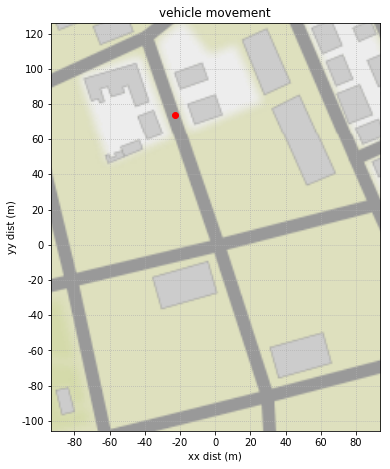

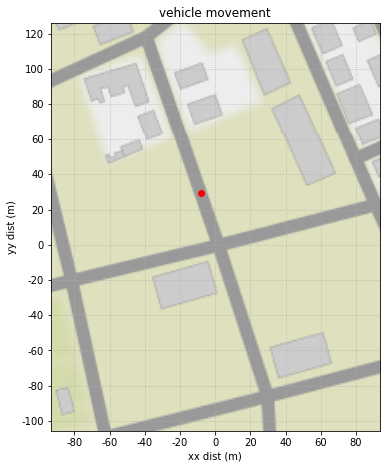

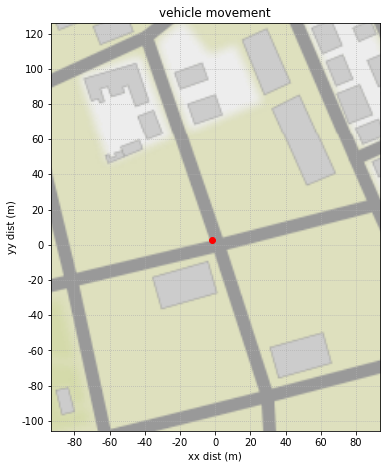

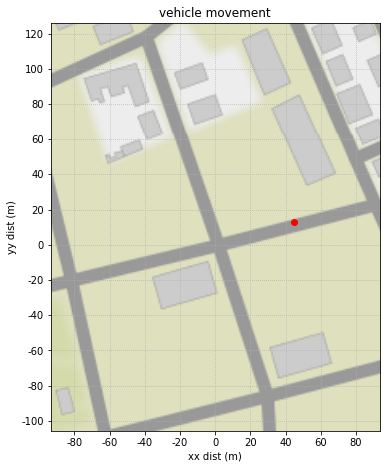

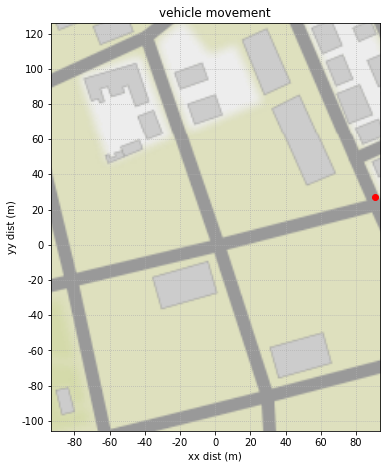

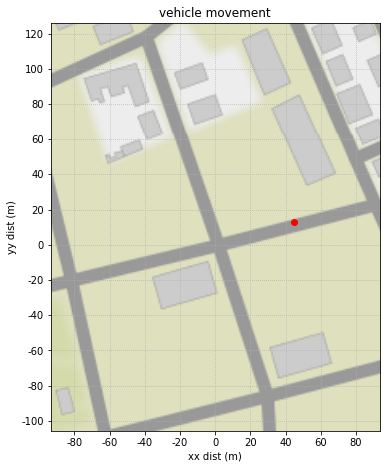

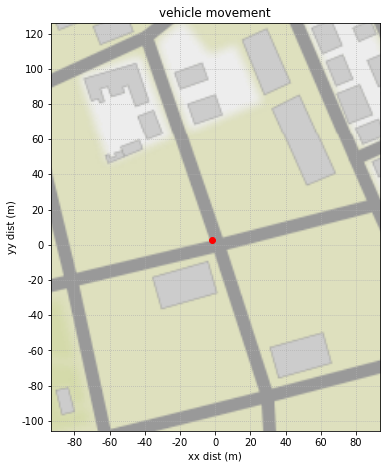

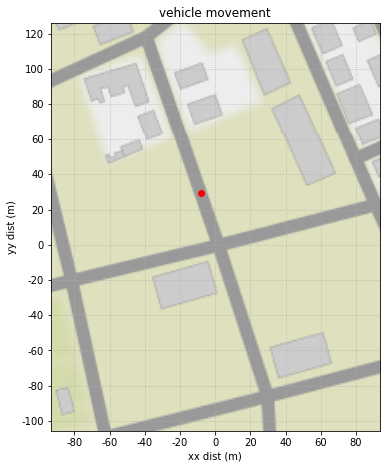

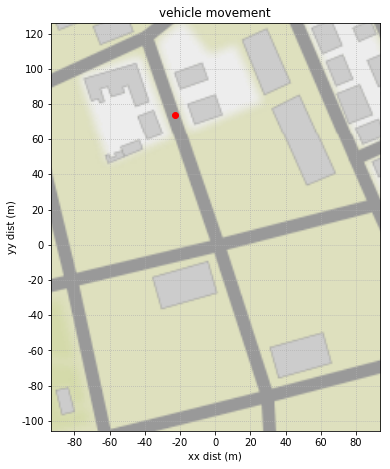

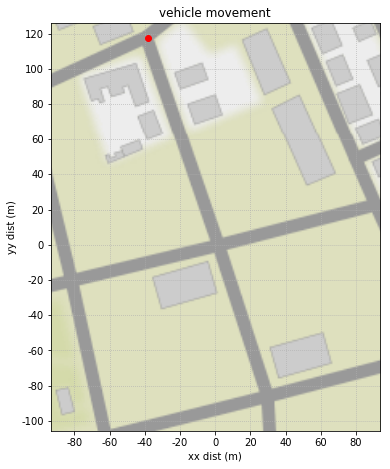

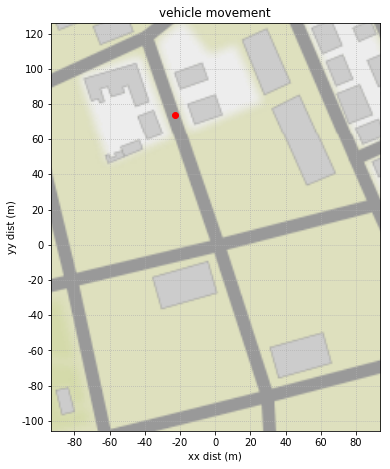

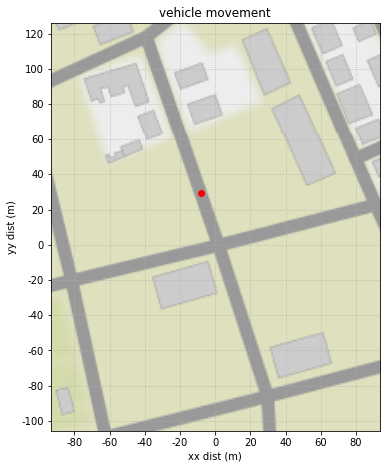

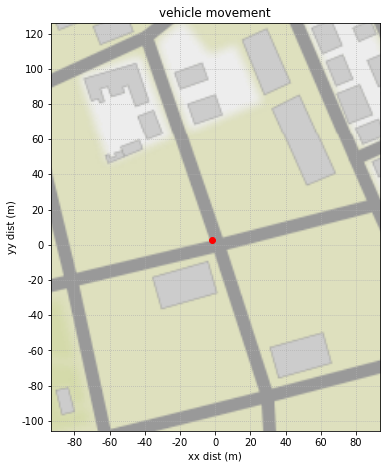

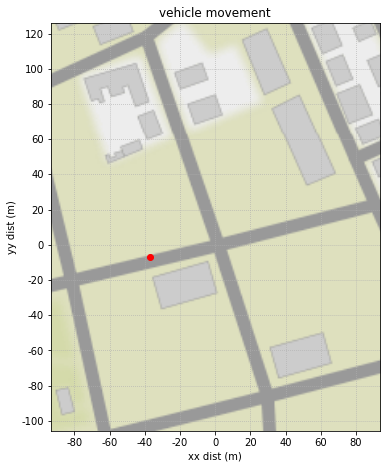

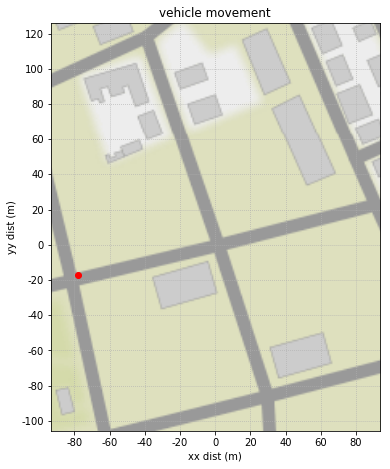

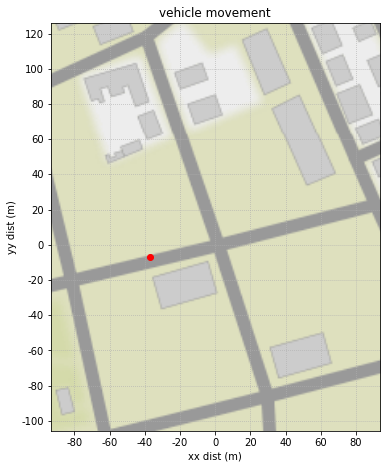

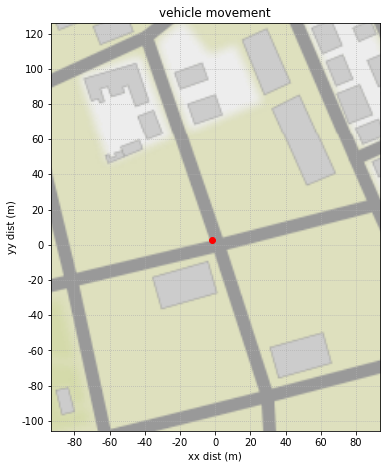

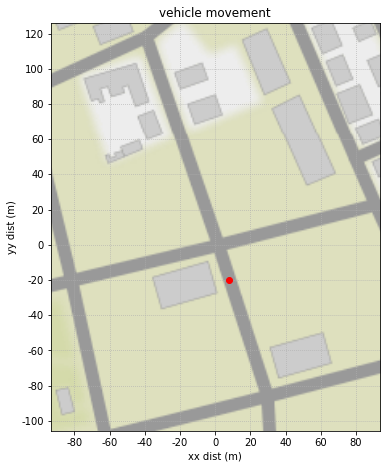

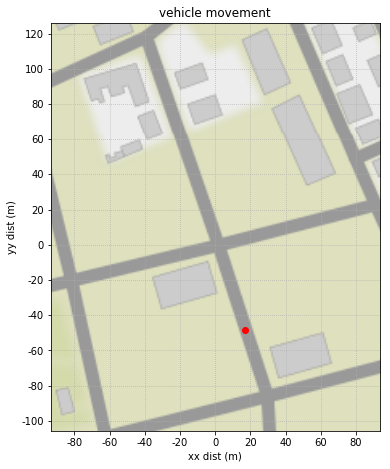

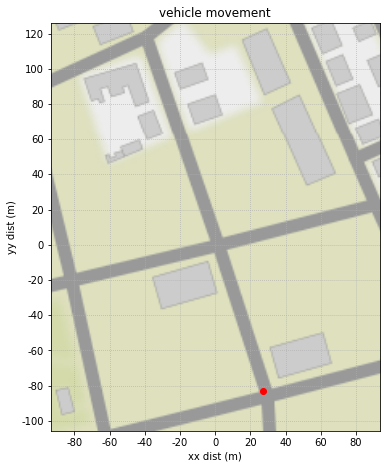

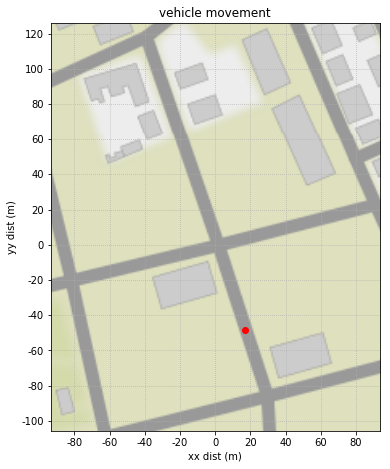

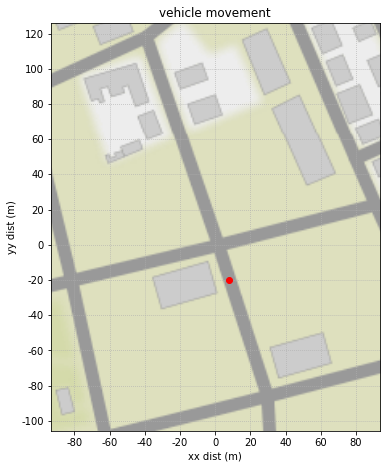

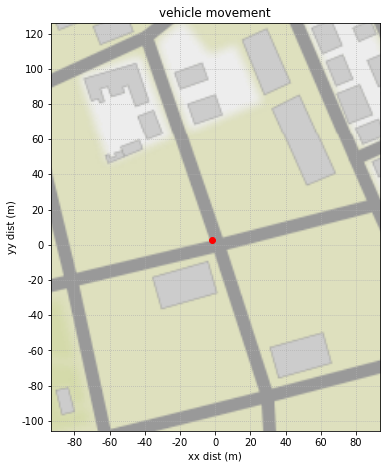

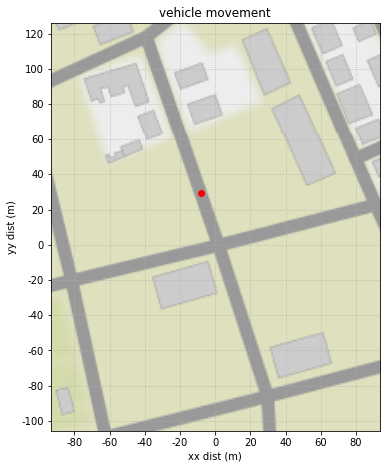

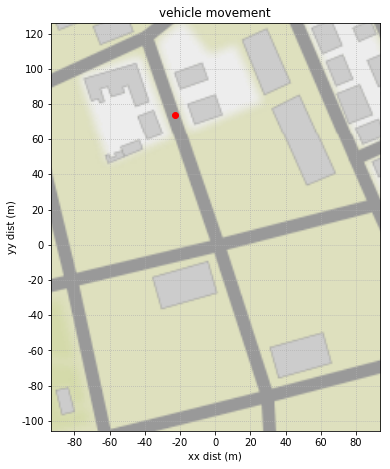

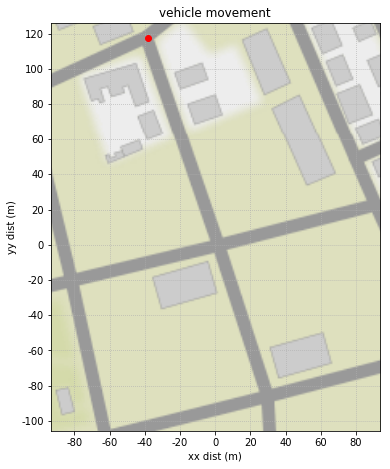

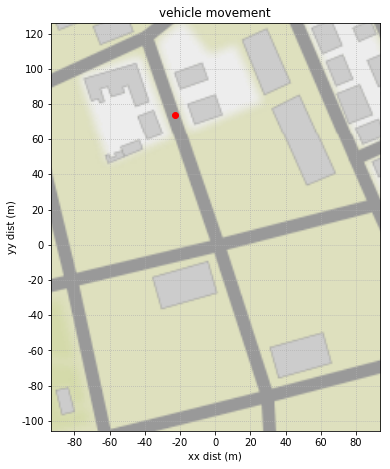

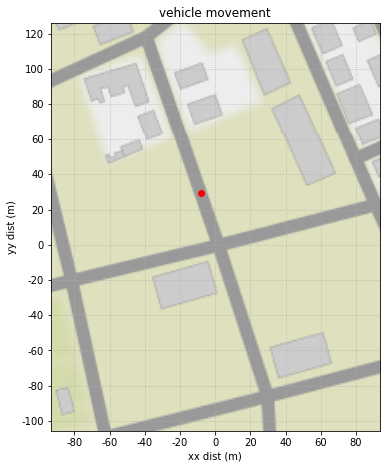

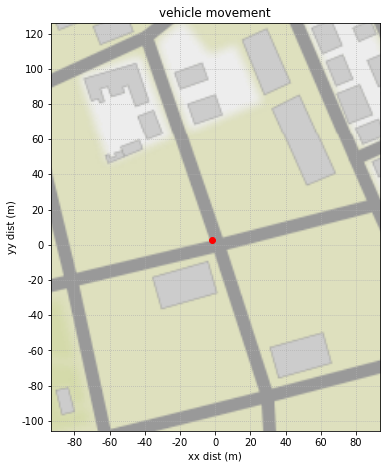

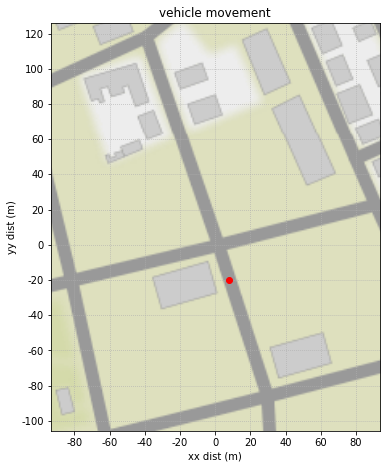

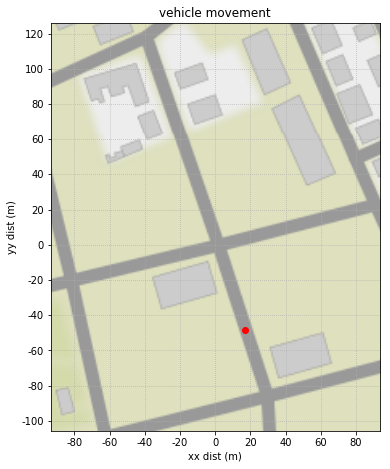

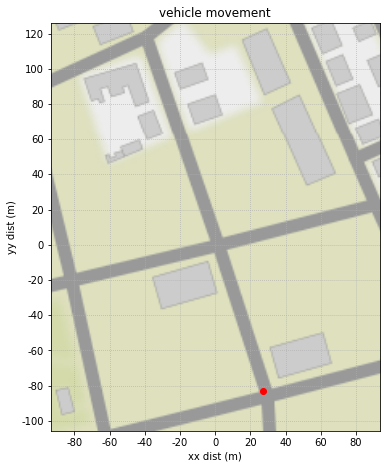

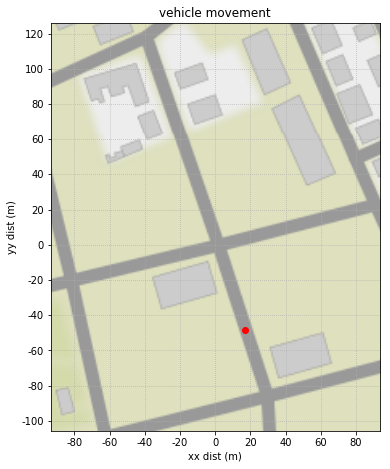

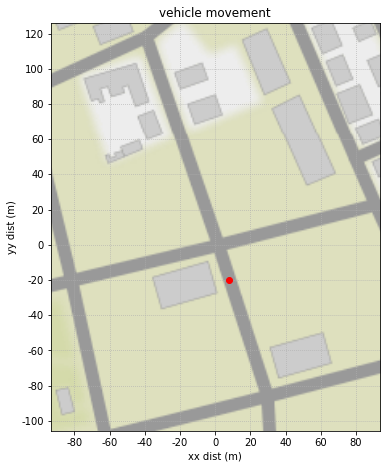

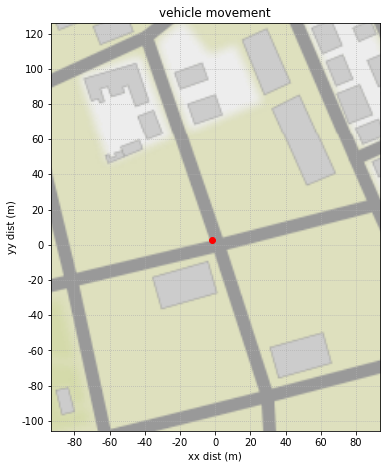

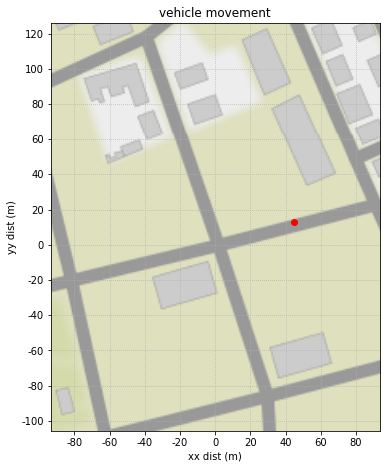

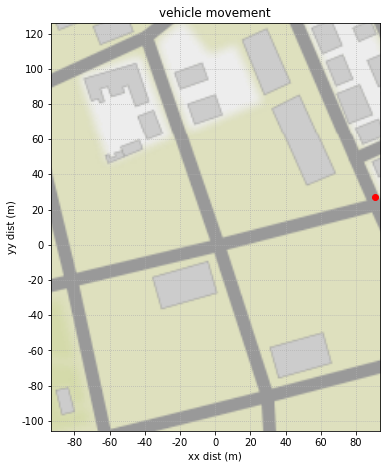

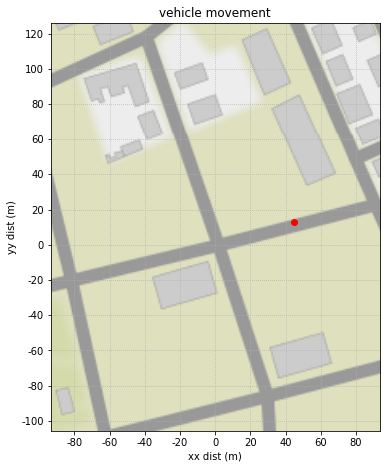

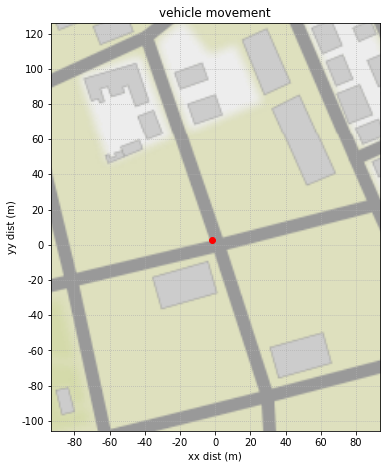

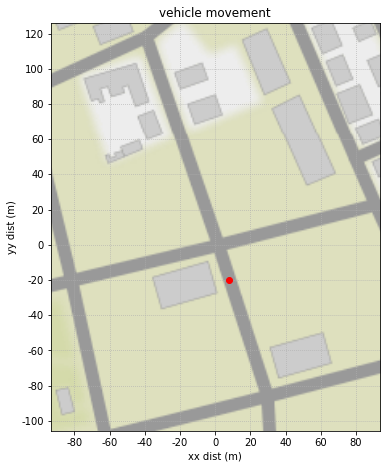

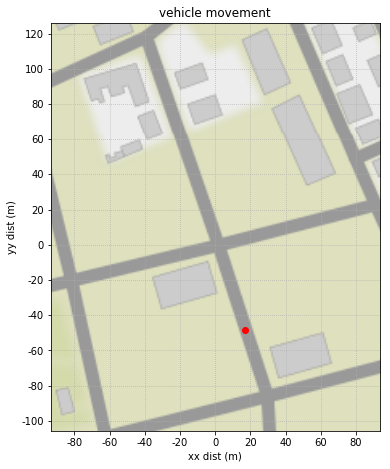

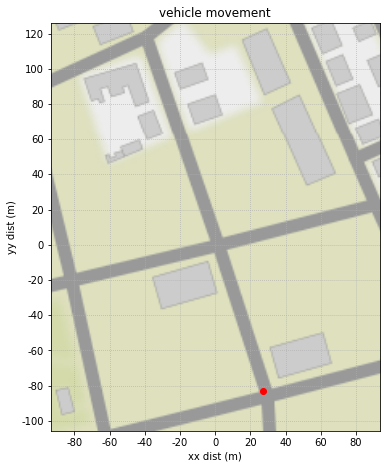

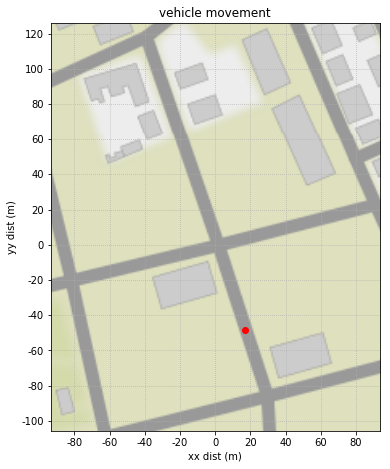

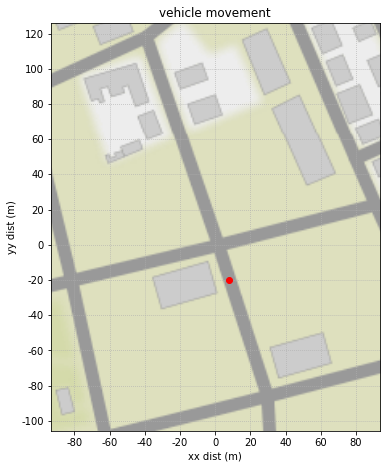

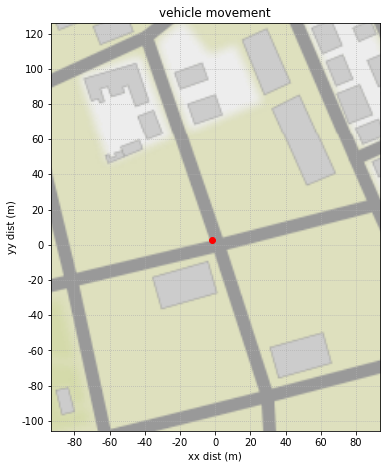

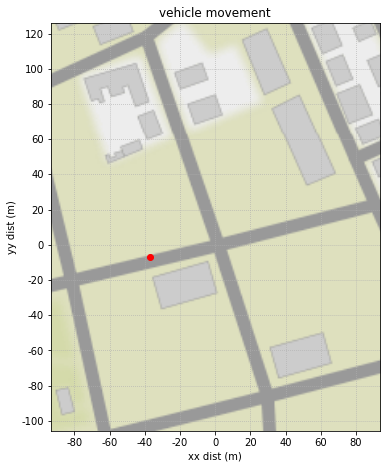

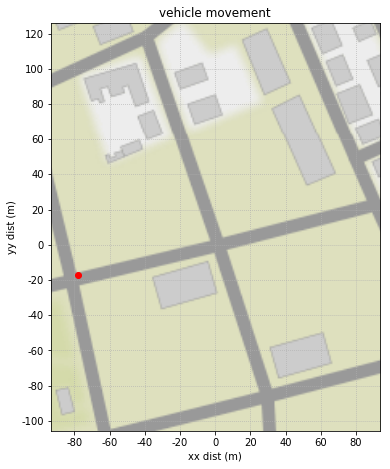

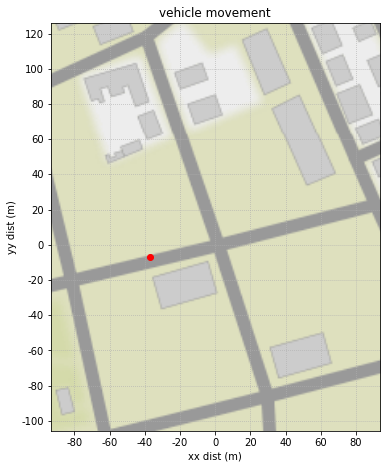

In [31]:
movement_dir = '/mnt/hgfs/data/vehicular-traces-gaia/graphs/movement'
movement_data = pd.read_csv(os.path.join(movement_dir, 'movement.csv'))

for i, row in movement_data.iterrows():
    
    fig = plt.figure(figsize = (7.5, 7.5))
    ax = fig.add_subplot(1, 1, 1)
    ax.xaxis.grid(True, ls = 'dotted', lw = 0.75)
    ax.yaxis.grid(True, ls = 'dotted', lw = 0.75)

    # FIXME : use 'transparent' grid to make sure the whole picture shows up
    mspeed = mspeed.to_crs(epsg = 3857)
    mspeed.plot(ax = ax, zorder = 5, column = 'value', cmap = 'YlOrRd', legend = False, alpha = 0.0)
    add_basemap(ax, zoom = 17)

    xlim = ax.get_xlim()
    dx = (65.5 / 2.5)
    a = np.arange(LON_3857 - (dx * 10), LON_3857, dx)
    b = np.arange(LON_3857, LON_3857 + (dx * 20), dx)
    c = np.arange(-(20 * 10), 0, 20)
    d = np.arange(0, (20 * 20), 20)
    ax.set_xticks(a.tolist() + b.tolist())
    ax.set_xticklabels(c.tolist() + d.tolist())
    ax.set_xlim(xlim)
    
    ylim = ax.get_ylim()
    a = np.arange(LAT_3857 - (dx * 10), LAT_3857, dx)
    b = np.arange(LAT_3857, LAT_3857 + (dx * 20), dx)
    c = np.arange(-(20 * 10), 0, 20)
    d = np.arange(0, (20 * 20), 20)
    ax.set_yticks(a.tolist() + b.tolist())
    ax.set_yticklabels(c.tolist() + d.tolist())
    ax.set_ylim(ylim)
    
    ax.set_title('vehicle movement')
    ax.set_xlabel('xx dist (m)')
    ax.set_ylabel('yy dist (m)')
    
    vehicle_pos = gp.GeoDataFrame({'geometry' : [shapely.geometry.Point(row.lon, row.lat)]})
    vehicle_pos.crs = {'init' : 'epsg:4326'}
    vehicle_pos = vehicle_pos.to_crs(epsg = 3857)
    vehicle_pos.plot(ax = ax, zorder = 10, color = 'red')
    
    plt.savefig(os.path.join(movement_dir, ("movement-%02d.jpeg" % (i))), bbox_inches = 'tight', format = 'jpeg')


## throughput per 802.11 type

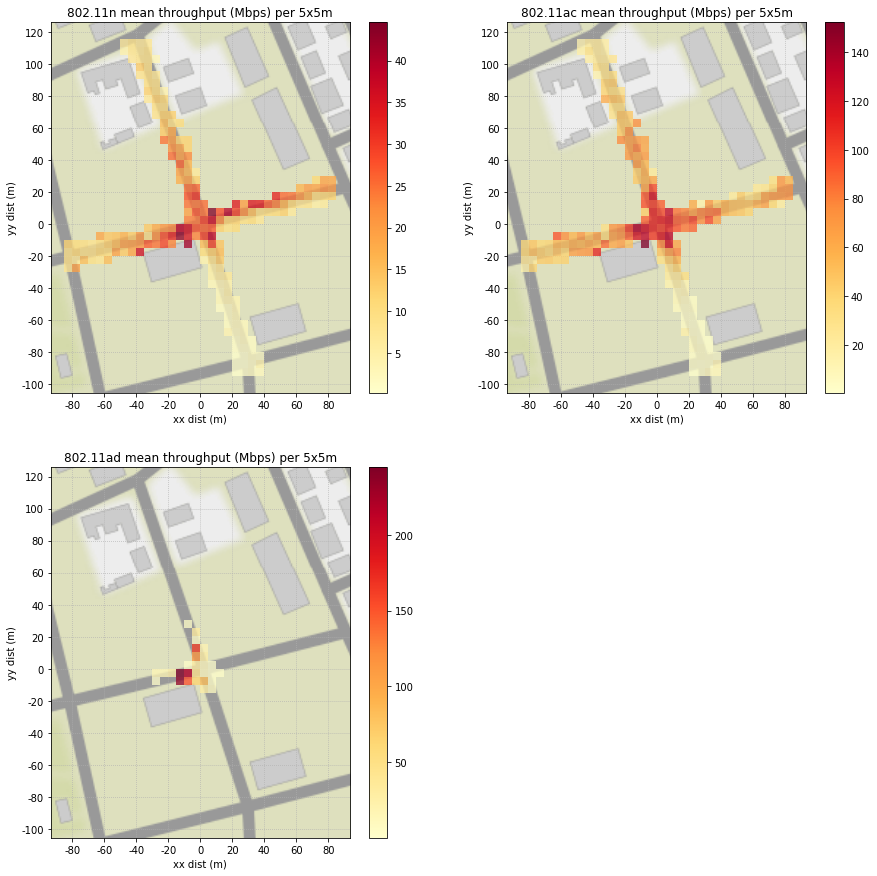

In [25]:
fig = plt.figure(figsize = (15.0, 15.0))
for i, wifi_type in enumerate(['n', 'ac', 'ad']):
    
    ax = fig.add_subplot(2, 2, 1 + i)
    ax.xaxis.grid(True, ls = 'dotted', lw = 0.75)
    ax.yaxis.grid(True, ls = 'dotted', lw = 0.75)
    
    mean_thghpt = trace_data[['cell_id', wifi_type]].groupby(['cell_id'])[wifi_type].mean().reset_index(drop = False, name = 'mean')
    mean_thghpt = pd.merge(grid, mean_thghpt, on = ['cell_id'], how = 'inner')

    mean_thghpt = mean_thghpt.to_crs(epsg = 3857)
    mean_thghpt[mean_thghpt['mean'] > 0.0].plot(ax = ax, zorder = 5, column = 'mean', cmap = 'YlOrRd', legend = True, alpha = .75)
    mean_thghpt[mean_thghpt['mean'] <= 0.0].plot(ax = ax, zorder = 0, column = 'mean', cmap = 'YlOrRd', legend = False, alpha = 0.0)
    add_basemap(ax, zoom = 17)

    xlim = ax.get_xlim()
    dx = (65.5 / 2.5)
    a = np.arange(LON_3857 - (dx * 10), LON_3857, dx)
    b = np.arange(LON_3857, LON_3857 + (dx * 20), dx)
    c = np.arange(-(20 * 10), 0, 20)
    d = np.arange(0, (20 * 20), 20)
    ax.set_xticks(a.tolist() + b.tolist())
    ax.set_xticklabels(c.tolist() + d.tolist())
    ax.set_xlim(xlim)
    
    ylim = ax.get_ylim()
    a = np.arange(LAT_3857 - (dx * 10), LAT_3857, dx)
    b = np.arange(LAT_3857, LAT_3857 + (dx * 20), dx)
    c = np.arange(-(20 * 10), 0, 20)
    d = np.arange(0, (20 * 20), 20)
    ax.set_yticks(a.tolist() + b.tolist())
    ax.set_yticklabels(c.tolist() + d.tolist())
    ax.set_ylim(ylim)
    
    ax.set_title('802.11%s mean throughput (Mbps) per 5x5m' % (wifi_type))
    ax.set_xlabel('xx dist (m)')
    ax.set_ylabel('yy dist (m)')

plt.savefig(os.path.join(graphs_dir, ("map-mean-thghpt.png")), bbox_inches = 'tight', format = 'png')
